<a href="https://colab.research.google.com/github/ArunVignesh75/Machine-Learning/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fraud Detection Model using DecisionTree 

#Dataset Information
 We have  to develop a model for predicting fraudulent transactions for a
financial company and use insights from the model to develop an actionable plan. Data for the
case is available in CSV format having 6362620 rows and 10 columns.

Dataset Contains:-

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



#Importing necessary Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report


#Loading the Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Fraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


#Exploratory Data Analysis

In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
df.shape

(6362620, 11)

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
df.dropna(inplace = True)

In [12]:
#Encoding the Data
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
df['type'].unique()

array([3, 4, 1, 2, 0])

In [14]:
df1 = df.copy()
df1

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


#Feature Engineering

Then we calculates the absolute difference between the 'oldbalanceOrg' and 'newbalanceOrig' columns and assigns the result to a new column 'diffOrigBal' in the DataFrame 'df'.

This new feature 'diffOrigBal' can potentially provide valuable information to the model during training. It may capture patterns or relationships that exist between the change in original balance and the occurrence of fraudulent transactions.

In [15]:
df['diffOrigBal'] = abs(df['oldbalanceOrg'] - df['newbalanceOrig'])
df['diffOrigBal']

0             9839.64
1             1864.28
2              181.00
3              181.00
4            11668.14
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: diffOrigBal, Length: 6362620, dtype: float64

And then, we calculates the absolute difference between the 'oldbalanceDest' and 'newbalanceDest' columns and assigns the result to a new column 'diffDestBal' in the DataFrame 'df'.

This new feature 'diffDestBal' can potentially provide valuable information to the model during training. It may capture patterns or relationships that exist between the change in destination balance and the occurrence of fraudulent transactions. For example, it could indicate unusual or unexpected changes in the destination account balance, which may be indicative of fraudulent activity.

In [16]:
df['diffDestBal'] = abs(df['oldbalanceDest'] - df['newbalanceDest'])
df['diffDestBal']


0                0.00
1                0.00
2                0.00
3            21182.00
4                0.00
              ...    
6362615     339682.13
6362616          0.00
6362617    6311409.27
6362618          0.00
6362619     850002.52
Name: diffDestBal, Length: 6362620, dtype: float64

df['amtToOrigBal'] = df['amount'] / df['oldbalanceOrg'] calculates the ratio of the transaction amount to the original balance of the origin account and assigns the result to a new column 'amtToOrigBal' in the DataFrame 'df'.

In [17]:
df['amtToOrigBal'] = df['amount'] / df['oldbalanceOrg']

when calculating the ratio of 'amount' to 'oldbalanceOrg', there may be situations where the denominator 'oldbalanceOrg' is zero, resulting in a division by zero error. This can lead to the creation of infinite values (inf) in the 'amtToOrigBal' column.

By performing these steps, the code ensures that the 'amtToOrigBal' column no longer contains infinite values, making it suitable for further analysis and modeling tasks that require numeric data without infinities.

In [18]:
max_val = df['amtToOrigBal'].replace([np.inf, -np.inf], np.nan).max()
df['amtToOrigBal'] = df['amtToOrigBal'].replace([np.inf, -np.inf], max_val).astype('float64')


In [19]:
df.isnull().sum()

step               0
type               0
amount             0
nameOrig           0
oldbalanceOrg      0
newbalanceOrig     0
nameDest           0
oldbalanceDest     0
newbalanceDest     0
isFraud            0
isFlaggedFraud     0
diffOrigBal        0
diffDestBal        0
amtToOrigBal      16
dtype: int64

In [20]:
df.dropna(inplace = True)

#Data Visualization

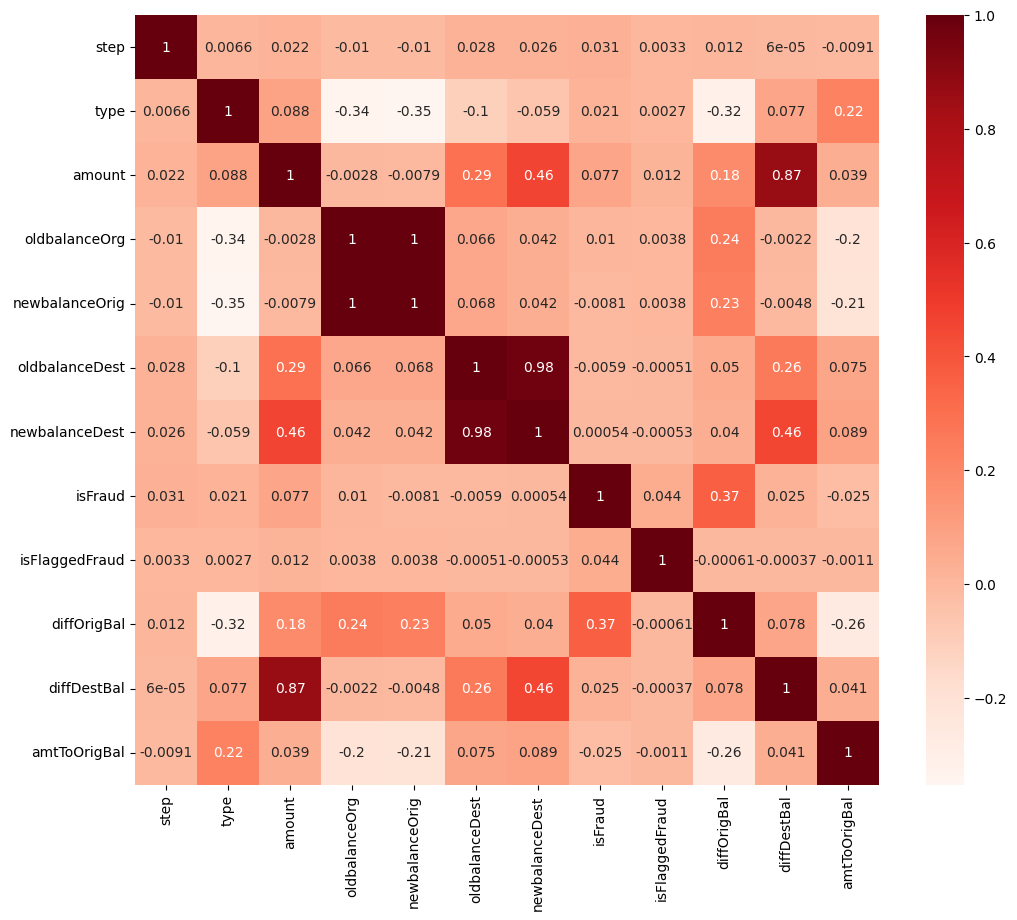

In [21]:
plt.figure(figsize=(12, 10))
cols = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'diffOrigBal', 'diffDestBal','amtToOrigBal']
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

#This Pie chart shows that the data is Imbalanced dataset, where target variable contains less than 1 percent to the whole data. 

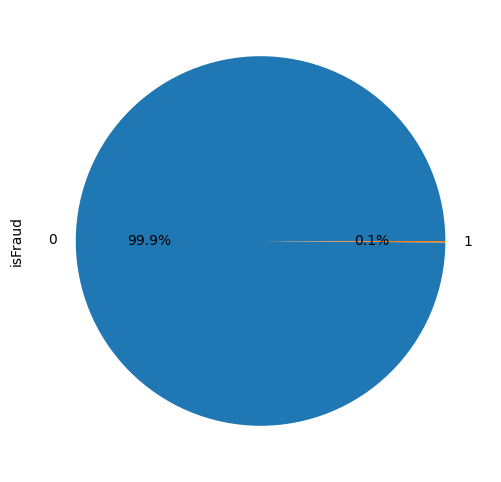

In [22]:
plt.figure(figsize=(8, 6))
df['isFraud'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()


In [23]:
df['isFraud'].value_counts()

0    6354407
1       8197
Name: isFraud, dtype: int64

#Bar-plot show how much transaction made on each type of transactions. 

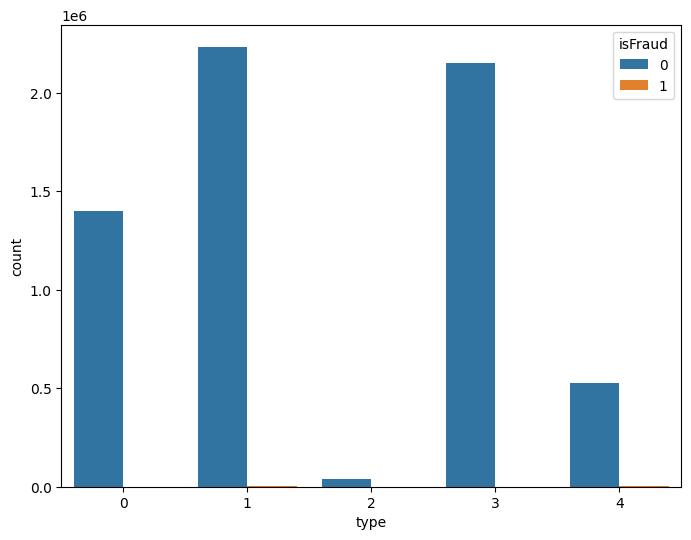

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.show()

#Spliting the Dataset

In [25]:
#drop irrelevant columns
df.drop(['nameOrig', 'step', 'amount', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
'newbalanceDest'], axis=1, inplace=True)

In [26]:
#split dataset into training and testing sets
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Using SMOTE to Balance the Dataset

In [28]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


#Initializing the DecisionTree Classifier Model

In [32]:
from sklearn.metrics import make_scorer
import numpy as np

for depth in [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60]:
    dt = DecisionTreeClassifier(max_depth=depth) # will tell the DT to not grow past the given threhsold
    # Fit dt to the resampled training set
    dt.fit(X_train_resampled, y_train_resampled) # the model is trained
    trainAccuracy = accuracy_score(y_train_resampled, dt.predict(X_train_resampled)) # this is useless information - i am showing to prove a point
    dt = DecisionTreeClassifier(max_depth=depth) # a fresh model which is not trained yet
    valAccuracy = cross_val_score(dt, X_train_resampled, y_train_resampled, cv=10, scoring = make_scorer(accuracy_score)) # syntax : cross_val_Score(freshModel,fts, target, cv= 10/5)
    print("Depth : ",depth, " Train accuracy : ",trainAccuracy, " Val Score : ", np.mean(valAccuracy))


Depth :  1  Train accuracy :  0.8189782851212154  Val Score :  0.8189781867504113
Depth :  2  Train accuracy :  0.988374876782074  Val Score :  0.9883737948453781
Depth :  3  Train accuracy :  0.9976500317794547  Val Score :  0.9976478679105375
Depth :  4  Train accuracy :  0.9979804161446318  Val Score :  0.9979788424199517
Depth :  5  Train accuracy :  0.9980004811671076  Val Score :  0.9979946780505898
Depth :  6  Train accuracy :  0.998017595450984  Val Score :  0.9980194642543603
Depth :  7  Train accuracy :  0.9980942162966145  Val Score :  0.9980863476650315
Depth :  8  Train accuracy :  0.9981855908352419  Val Score :  0.9981862793453649
Depth :  9  Train accuracy :  0.998221491488201  Val Score :  0.9982232619386741
Depth :  10  Train accuracy :  0.9982621133229191  Val Score :  0.9982613264658514
Depth :  20  Train accuracy :  0.9986472830680915  Val Score :  0.9985301387442058
Depth :  30  Train accuracy :  0.9988939648149995  Val Score :  0.9983675530458516
Depth :  40  Tra

#Tuning the Model

In [33]:
model = DecisionTreeClassifier(max_depth = 10)
#Fit dt to the training set
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=10)

#Evaluating the Model on Test Set

In [34]:
model.score(X_test, y_test) # scoring the model

0.9999952849501108

In [35]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

#Evaluating the Model

In [38]:
#Accuracy score
accuracy_score(y_test,y_pred)

0.9999952849501108

In [39]:
#F1 Score
f1_score(y_test,y_pred)

0.9981060606060606

In [36]:
#Auroc Score
auc_score = roc_auc_score(y_test,y_pred)
auc_score

0.998109640831758

#Classification Report

In [37]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270934
           1       1.00      1.00      1.00      1587

    accuracy                           1.00   1272521
   macro avg       1.00      1.00      1.00   1272521
weighted avg       1.00      1.00      1.00   1272521



#Describe your fraud detection model in elaboration:


The fraud detection model used in this code is a Decision Tree Classifier. It is a supervised learning algorithm that is commonly used for classification tasks. The model is trained on a dataset that contains features related to fraudulent transactions. The target variable is "isFraud," which indicates whether a transaction is fraudulent or not.
The dataset is preprocessed by encoding categorical variables using label encoding and handling missing values by dropping rows with missing data. Some additional features are created, such as the absolute difference between the old and new balance of the origin and destination accounts, and the ratio of the transaction amount to the old balance of the origin account.

The dataset is then split into training and testing sets, and the training set is further resampled using the Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance. The Decision Tree model is trained on the resampled training set and evaluated using cross-validation to estimate its performance.

Finally, the model is evaluated on the testing set using various performance metrics such as accuracy, precision, recall, F1-score, and the classification report. The model achieves high accuracy and F1-score, indicating its effectiveness in predicting fraudulent transactions.

#How did you select variables to be included in the model?


The variables included in the model are selected based on their relevance to the task of fraud detection. In this code, some variables are dropped from the dataset as they are considered irrelevant for the prediction task. These variables are 'nameOrig', 'step', 'amount', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest'.
The remaining variables, such as 'type', 'isFlaggedFraud', 'diffOrigBal', 'diffDestBal', and 'amtToOrigBal', are considered informative and retained for model training. The decision to include or exclude variables depends on the domain knowledge, data exploration, and understanding of the problem.

#Demonstrate the performance of the model using the best set of tools:
The performance of the model is demonstrated using various evaluation metrics and visualization tools. In this code, the classification report is generated, which provides precision, recall, F1-score, and support for each class (fraudulent and non-fraudulent). The accuracy score is also calculated to measure the overall accuracy of the model.
Additionally, a heatmap is created to visualize the correlation between different features in the dataset. Pie charts and count plots are used to visualize the distribution of fraudulent transactions and the relationship between transaction types and fraud.

#What are the key factors that predict fraudulent customers?

Potential key factors could be:
Transaction type: Certain transaction types might be more prone to fraud than others.
Flagged transactions: Transactions that are flagged as potentially fraudulent by the system.
Difference in account balances: The absolute difference between the old and new balances of origin and destination accounts.
Amount to original balance ratio: The ratio of the transaction amount to the old balance of the origin account.

#Do these factors make sense? If yes, how? If not, how not?


These factors make sense in the context of fraud detection. Transaction type can be a significant factor as certain types of transactions may be more susceptible to fraudulent activities. Flagged transactions are also important as they indicate suspicious or potentially fraudulent behavior.
The difference in account balances and the ratio of transaction amount to the original balance can provide insights into abnormal or unexpected transaction patterns, which can be indicative of fraudulent activity. For example, unusually large transactions compared

#What kind of prevention should be adopted while the company updates its infrastructure?
When updating the infrastructure to enhance fraud prevention, several measures can be adopted:

a. Advanced Authentication: Implement strong user authentication methods such as two-factor authentication (2FA) or biometric authentication to ensure secure access to accounts and systems.

b. Real-time Monitoring: Set up real-time monitoring systems to detect and flag suspicious activities, such as unusual transaction patterns or multiple failed login attempts.

#Assuming these actions have been implemented, how would you determine if they work?

To determine the effectiveness of the implemented prevention measures, several evaluation methods can be employed:
a. Monitoring Metrics: Continuously monitor key metrics related to fraud detection and prevention, such as the number of detected fraud cases, false positives, and false negatives. A decrease in the number of successful fraud attempts and false positives can indicate the effectiveness of the measures.

b. Performance Evaluation: Assess the performance of machine learning models used for fraud detection. Measure metrics such as accuracy, precision, recall, and F1-score on a regular basis to ensure the models are effectively identifying fraudulent transactions while maintaining acceptable performance levels.